# 2 Structural Roles: Rolx and ReFex

In [2]:
import snap
import numpy as np
import matplotlib.pyplot as plt

## 2.0 Loading Graph

In [4]:
G = snap.TUNGraph.Load(snap.TFIn('hw1-q2.graph'))

In [11]:
print('Number of nodes:', G.GetNodes())
print('Number of edges:', G.GetEdges())

Number of nodes: 1589
Number of edges: 2742


Node Ids are natually 0 - 1588

## 2.1 Basic Features

In [177]:
def BasicFeature(Graph):
    N, E = Graph.GetNodes(), Graph.GetEdges()
    V = np.zeros((N, 3), dtype=int)
    # degree 
    for node in Graph.Nodes():
        V[node.GetId(), 0] = node.GetDeg()
        
    # #Edges in the egonet 
    # #Edges that connect the egonet and the rest of the graph
    # It is obvious that #interedges + #infraedges * 2 = sum(node degree for node in egonet). 
    for node in Graph.Nodes():
        node_id = node.GetId()
        egonet_ids = snap.TIntV()
        egonet_ids.Add(node_id)
        for i in range(node.GetDeg()):
            egonet_ids.Add(node.GetNbrNId(i))
        egonet = snap.GetSubGraph(Graph, egonet_ids)
        V[node_id, 1] = egonet.GetEdges()
        V[node_id, 2] = np.sum([V[egonet_id, 0] for egonet_id in egonet_ids]) - 2 * V[node_id, 1]
        
    return V.astype(float)

In [180]:
V = BasicFeature(G)
print(V)

[[ 2.  3.  1.]
 [ 3.  4.  0.]
 [ 4. 10.  0.]
 ...
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 2.  3. 10.]]


Similarity

In [181]:
# compute similarity matrix
V_norm=np.linalg.norm(V, axis=1, keepdims=True)
Sim = np.matmul(V, np.transpose(V)) / V_norm / np.transpose(V_norm)
Sim[np.isnan(Sim)] = 0

/home/ubuntu/anaconda3/envs/snap/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [182]:
indices = list(np.argsort(Sim[9, :]))
print('Top 5 nodes that are most similar to node 9:')
# indices[-1] = 9
for i in range(-2, -7, -1):
    print('Node %4d:   %.6f' % (indices[i], Sim[9, indices[i]]))

Top 5 nodes that are most similar to node 9:
Node  415:   0.999616
Node  286:   0.996344
Node  288:   0.996344
Node 1336:   0.996118
Node 1054:   0.996118


## 2.2 Recursive Feature

In [183]:
def RecursiveFeature(Graph, BasicFeature, K=2):
    V = BasicFeature
    for i in range(K):
        V_mean = np.zeros_like(V)
        V_sum = np.zeros_like(V)
        for node in Graph.Nodes():
            node_id = node.GetId()
            degree = node.GetDeg()
            if degree == 0:
                continue
            for i in range(node.GetDeg()):
                V_sum[node_id, :] += V[node.GetNbrNId(i), :]
            V_mean[node_id, :] = V_sum[node_id, :] / V[node_id, 0]
        V = np.hstack([V, V_mean, V_sum])
    return V

In [185]:
V2 = RecursiveFeature(G, V, K=2)
print(V2)

[[  2.   3.   1. ...  10.  14.   5.]
 [  3.   4.   0. ...  13.  18.   2.]
 [  4.  10.   0. ...  64. 160.   0.]
 ...
 [  1.   1.   1. ...   2.   2.   2.]
 [  1.   1.   1. ...   2.   2.   2.]
 [  2.   3.  10. ...  52. 105. 111.]]


In [187]:
V2_norm=np.linalg.norm(V2, axis=1, keepdims=True)
Sim2 = np.matmul(V2, np.transpose(V2)) / V2_norm / np.transpose(V2_norm)
Sim2[np.isnan(Sim2)] = 0
Sim2[9, :]

/home/ubuntu/anaconda3/envs/snap/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([0.90522736, 0.94258066, 0.90975982, ..., 0.64500737, 0.64500737,
       0.83365497])

In [189]:
indices = list(np.argsort(Sim2[9, :]))
print('Top 5 nodes that are most similar to node 9:')
# indices[-1] = 9
for i in range(-2, -7, -1):
    print('Node %4d:   %.6f' % (indices[i], Sim2[9, indices[i]]))

Top 5 nodes that are most similar to node 9:
Node  973:   0.995985
Node  537:   0.994613
Node  415:   0.993728
Node  496:   0.992284
Node   25:   0.992241


It changes a lot! Node 415 is the only common node. \
The results are different because we use different feature set. In particular, V2 use multi-hop informations, while V0 use only the local information within the egonet. 

## 2.3 Role Discovery

Histogram of cosine similarities

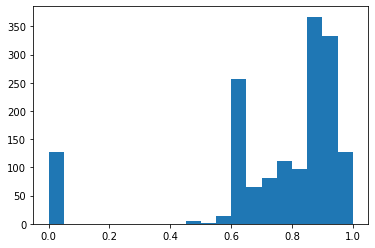

In [191]:
plt.hist(Sim2[9, :], bins=20)
plt.show()

There are about 3 roles: one around zero similarity (which has a degree of zero), one around 0.6, and one around 0.9